# 🔍 Predicting Item Prices from Descriptions (Part 2)
---
- Data Curation & Preprocessing
- ➡️ Model Benchmarking – Traditional ML vs LLMs
- E5 Embeddings & RAG
- Fine-Tuning GPT-4o Mini
- Evaluating LLaMA 3.1 8B Quantized
- Fine-Tuning LLaMA 3.1 with QLoRA
- Evaluating Fine-Tuned LLaMA 
- Summary & Leaderboard

--- 

# ⚔️ Part 2: Traditional ML vs LLMs

- Tasks:
    - Vectorize text (BoW, Word2Vec)
    - Train SVR, LR, XGBoost models
    - Predict with LLMs (GPT-4o, Claude, LLaMA…)
    - Compare traditional ML vs LLMs
  
📊 Which model predicts prices best? Let’s find out.

- 🧑‍💻 Skill Level: Advanced
- ⚙️ Hardware: ✅ CPU is sufficient — no GPU required
- 🛠️ Requirements: 🔑 HF Token, Open API Key, Anthropic API key, Groq API key

⚠️ This notebook assumes you're familiar with NLP techniques (e.g., converting text to vectors using Bag-of-Words or Word2Vec) and traditional ML models (like SVR, Logistic Regression, XGBoost) along with basic evaluation metrics.

---
📢 Find more LLM notebooks on my [GitHub repository](https://github.com/lisekarimi/lexo)

In [ ]:
# imports

import os
import importlib
import re
import csv
import tiktoken
import math
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.svm import LinearSVR
import xgboost as xgb
from dotenv import load_dotenv
from openai import OpenAI
from anthropic import Anthropic

## 📥 Load Dataset

In [ ]:
# #If you face NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported run:
# %pip install -U datasets

In [ ]:
HF_USER = "lisekarimi"
DATASET_NAME = f"{HF_USER}/pricer-data"

dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [ ]:
print(train[0]["text"])

In [ ]:
print(train[0]["price"])

## 🛠️ Prepare Data for models

In [ ]:
def mask_price_value(text):
    return re.sub(r"(\n\nPrice is \$).*", r"\1", text)

In [ ]:
# Extract prices
prices = np.array([float(datapoint["price"]) for datapoint in train])

# Extract cleaned prompts
documents = [mask_price_value(datapoint["text"]) for datapoint in train]

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
print(documents[0])

## 📊 Model Evaluation with testing.py

- Runs predictions and computes errors on test data
- Metrics: Absolute error, RMSLE, and hit rate
- Visual: Scatter plot of predicted vs. actual prices (color-coded)

In [ ]:
import helpers.testing
importlib.reload(helpers.testing)

from helpers.testing import Tester  # noqa: E402

results = {}  # Store each model's tester to compare and find the best performer

## 🎯 Price Prediction with Traditional ML

## Bag-of-Words + Linear Regression

In [ ]:
# Use the CountVectorizer for a Bag of Words model
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

def bow_lr_pricer(datapoint):
    x = vectorizer.transform([mask_price_value(datapoint["text"])])
    return max(regressor.predict(x)[0], 0)

tester = Tester(bow_lr_pricer, test)
tester.run()
results["Bag of Words LR"] = tester

Bow Lr Pricer Error=$121.23 RMSLE=0.98 Hits=27.2%

## Word2Vec + Linear Regression

In [ ]:
# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=4)

# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

def word2vec_lr_pricer(datapoint):
    doc = mask_price_value(datapoint["text"])
    vec = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([vec])[0])

tester = Tester(word2vec_lr_pricer, test)
tester.run()
results["Word2Vec LR"] = tester

Word2Vec Lr Pricer Error=$127.42 RMSLE=0.97 Hits=27.6%

## Word2Vec + Linear SVR

In [ ]:
svr_regressor = LinearSVR()
svr_regressor.fit(X_w2v, prices)

def svr_pricer(datapoint):
    np.random.seed(42)
    doc = mask_price_value(datapoint["text"])
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

tester = Tester(svr_pricer, test)
tester.run()
results["Word2Vec SVR"] = tester

Svr Pricer Error=$124.24 RMSLE=0.98 Hits=28.4%

## Word2Vec + XGBoost 

I initially tried Random Forest, but it struggled with high training time and didn’t scale well with this data.
That’s why I opted for XGBoost — it’s faster, handles large datasets efficiently, and often delivers better performance on structured data.

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)
xgb_model.fit(X_w2v, prices)

def xgboost_pricer(datapoint):
    doc = mask_price_value(datapoint["text"])
    doc_vector = document_vector(doc)
    return max(0, xgb_model.predict([doc_vector])[0])

tester = Tester(xgboost_pricer, test)
tester.run()
results["Word2Vec XGBoost"] = tester


Xgboost Pricer Error=$107.97 RMSLE=0.84 Hits=29.2%

## 🚀 Price Prediction with Frontier LLMs

In [ ]:
load_dotenv(override=True)

# Get API keys from environment
openai_api_key = os.getenv('OPENAI_API_KEY')
if not openai_api_key:
   print("❌ OPENAI_API_KEY is missing")

anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
if not anthropic_api_key:
   print("❌ ANTHROPIC_API_KEY is missing")

groq_api_key = os.getenv('GROQ_API_KEY')
if not groq_api_key:
   print("❌ GROQ_API_KEY is missing")

# Initialize clients
openai = OpenAI(api_key=openai_api_key)
claude = Anthropic(api_key=anthropic_api_key)
groq = OpenAI(api_key=groq_api_key, base_url="https://api.groq.com/openai/v1")

In [ ]:
def messages_for(datapoint):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = mask_price_value(datapoint["text"]).replace(" to the nearest dollar", "").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

messages_for(train[0])

In [ ]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

get_price("The price is roughly $99.99 because blah blah") # Testing

In [ ]:
# A utility function to Count the tokens before passing the prompt to the model

def count_tokens(messages):
    encoding = tiktoken.get_encoding("cl100k_base")
    token_count = sum(len(encoding.encode(message['content'])) for message in messages)
    return token_count


### gpt-4o-mini

In [ ]:
# Count tokens once before running
total_tokens = 0
for datapoint in train:
    messages = messages_for(datapoint)
    total_tokens += count_tokens(messages)
print(f"Total tokens: {total_tokens}")

def gpt_4o_mini(datapoint):
    messages = messages_for(datapoint)
    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

tester = Tester(gpt_4o_mini, test)
tester.run()
results["gpt 4o mini"] = tester

Gpt 4o Mini Error=$99.30 RMSLE=0.75 Hits=44.8%

### gpt 4o (the big guy 😎)

In [ ]:
def gpt_4o_frontier(datapoint):
    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=messages_for(datapoint),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

tester = Tester(gpt_4o_frontier, test)
tester.run()
results["gpt 4o (the big guy)"] = tester

Gpt 4O Frontier Error=$87.68 RMSLE=1.01 Hits=51.2%

### claude 3.7 Sonnet

In [ ]:
def claude_3_point_7_sonnet(datapoint):
    messages = messages_for(datapoint)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-7-sonnet-20250219",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

tester = Tester(claude_3_point_7_sonnet, test)
tester.run()
results["claude 3.7 sonnet"] = tester

Claude 3 Point 7 Sonnet Error=$110.26 RMSLE=0.60 Hits=46.0%

### groq model

In [ ]:
def llama3_groq_pricer(datapoint):
    response = groq.chat.completions.create(
        model="llama3-70b-8192",
        messages=messages_for(datapoint),
        max_tokens=5,
        seed=42
    )
    reply = response.choices[0].message.content
    return get_price(reply)

tester = Tester(llama3_groq_pricer, test)
tester.run()
results["llama3-70b-8192"] = tester

Llama3 Groq Pricer Error=$122.95 RMSLE=0.73 Hits=44.8%

In [ ]:
def deepseek_qwen_pricer(datapoint):
    response = groq.chat.completions.create(
        model="deepseek-r1-distill-qwen-32b",
        messages=messages_for(datapoint),
        max_tokens=5,
        seed=42
    )
    reply = response.choices[0].message.content
    return get_price(reply)

tester = Tester(deepseek_qwen_pricer, test)
tester.run()
results["deepseek-qwen-32b"] = tester

Deepseek Qwen Pricer Error=$178.96 RMSLE=0.83 Hits=33.2%

## 🕵️ Human Judgement Baseline (Ed)

We include a human baseline from our instructor Ed, who manually estimated prices based on item descriptions (💪 thanks Ed for taking on this exhausting task!). This allows us to compare model performance against human intuition.

In [ ]:
human_predictions = []

with open('data/human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

def human_pricer(datapoint):
    # `Tester` runs in order, so use the index from Tester itself
    idx = human_pricer.counter
    human_pricer.counter += 1
    return human_predictions[idx]

human_pricer.counter = 0  # initialize counter

tester = Tester(human_pricer, test)
tester.run()
results["Human Predictions"] = tester

## 🥇 Benchmark Showdown: ML, LLMs, and Ed

In [ ]:
def truncate(x, decimals=2):
    factor = 10 ** decimals
    return math.floor(x * factor) / factor

df_results = []

for model_name, tester in results.items():
    avg_error = truncate(sum(tester.errors) / tester.size)
    hit_percent = truncate(sum(1 for c in tester.colors if c == "green") / tester.size * 100)
    rmsle = truncate(math.sqrt(sum(tester.sles) / tester.size))

    df_results.append({
        "model": model_name,
        "avrg_error": avg_error,
        "rmsle": rmsle,
        "accuracy_%": hit_percent
    })

df_results = pd.DataFrame(df_results)
df_results = df_results.sort_values(by="avrg_error")

# Display with .2f formatting
print(df_results.to_string(index=False, float_format="{:.2f}".format))


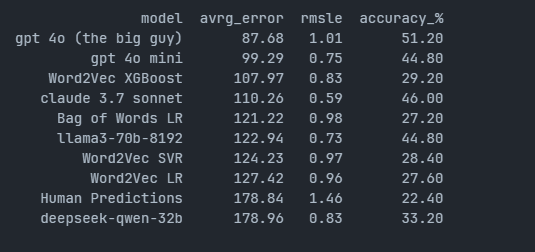

🏁 **GPT-4o, GPT-4o Mini and XGBoost** clearly outperformed both LLMs (like Claude 3.7, LLaMA3-70B, DeepSeek-32B) and traditional ML approaches (LR, SVR).

Now let’s take the top-performing frontier LLM — **GPT-4o Mini** — to test if retrieval (RAG) boosts its performance, and the best ML model — **XGBoost** — to see if contextual embeddings enhance its predictions.

Let’s find out.

🔜 See you in the [next notebook](https://github.com/lisek75/nlp_llms_notebook/blob/main/09_part3_e5embeddings_rag.ipynb)